# NHS Mental Health Data Analysis

The following project analyses 5 data sets containing information about mental health therapy provision in England through the NHS. The data sets cover April - August 2014 and were retreived from: https://data.england.nhs.uk/organization/hscic.
<br>
The analysis aimed to investigate the following question: 
<br>
> **What proportion of people seeking mental health treatment were provided with it from April - August and how did this vary in different regions of England?**  

I aimed to do this by comparing the number of people recorded as being in contact with NHS services with the number assigned __[CPA](https://www.nhs.uk/conditions/social-care-and-support-guide/help-from-social-services-and-charities/care-for-people-with-mental-health-problems-care-programme-approach/)__ (care programme approach) support. These figures would be compared for each __[CCG](https://www.england.nhs.uk/ccgs/)__ (clinical commissioning group), which were grouped into the different __[regions of England](https://en.wikipedia.org/wiki/Regions_of_England)__, to compare care provision in different areas of England.

## Section 1: Load Libraries and Datasets
Libraries to be used for data analysis were: pandas, matplotlib and numpy. The requests and BeautifulSoup libraries would be used later for scraping the regions of England from Wikipedia. The OS library was used to load CSV files from the file folder.  
I downloaded the data sets from the __[link](https://data.england.nhs.uk/organization/hscic)__ provided above.
### 1.1: Libraries

In [106]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import requests
from bs4 import BeautifulSoup

### 1.2: Load CSVs
The functions below generate dataframes for each month's mental health dataset. The final function generates a sub-dataframe for each of these, which retains only the 'CCG', 'People in contact with services' and 'People on CPA' columns.
<br>
*Note: all dataframes are stored within dictionaries throughout this project*.

In [107]:
def df_month_gen(month):
    os.chdir('/Users/Patrick/Documents/Python/PythonScripts/Pandas/MentalHealth')
    file_names = os.listdir()
    for file in file_names:
        file_words = file.split('-')
        if month in file_words:
            read_file = file
    
    return pd.read_csv(read_file,na_values=['*','-'])

def df_generator(month_list):
    dfs = {}
    for month in month_list:
        dfs[month+'_df'] = df_month_gen(month)
    return dfs

def df_sub_generator(df_dict):
    df_subs = {}
    cols = ['CCG','People in contact with services','People on CPA']
    may_cols = ['CCG Name','People in contact with services','People on CPA']
    for df_key in df_dict:
        sub_key = df_key[:-2] + 'sub'
        if df_key == 'may_df':
            df_subs[sub_key] = df_dict[df_key][may_cols]
        else:
            df_subs[sub_key] = df_dict[df_key][cols]
    return df_subs

In [108]:
# get dataframes for the apr, may, jun, jul and aug csvs
month_dfs = df_generator(['apr','may','jun','july','aug'])
# for each df, make a sub-frame containing only people in contact, ccg and people on cpa plans
month_subs = df_sub_generator(month_dfs)

## Section 2: Data Cleaning
The main cleaning tasks are:
- Remove NaNs
- Remove duplicate CCG entries
- Rename columns
- Abbreviate the CCG names  

Note: the default NaN entry of the original datasets was a hyphen or asterix, but these were converted to np.nan objects when loading the CSV files.

### 2.1: Clean DFs
Time to create a new dictionary with the cleaned dataframes.

In [109]:
def col_rename(df_in):
    new_col_names = ['ccg','people_in_contact','on_cpa']
    old_col_names = df_in.columns
    num = len(old_col_names)
    new_df = df_in.rename(columns={old_col_names[j]:new_col_names[j]
                                 for j in range(num)})
    return new_df

def remove_repeats(df_in):
    df_in = df_in.sort_values(by=['people_in_contact','on_cpa'],
                              ascending=False)
    return df_in.drop_duplicates(['ccg'])

def ccg_col_abr(df_in):
    new_ccg = (df_in['ccg'].str.split(' ')).str[1:-1]
    new_ccg = new_ccg.str.join(' ')
    new_ccg = new_ccg.replace('', 'NO CCG')
    new_ccg = new_ccg.str.title()
    df_in['ccg'] = new_ccg
    return df_in

def apply_cleaning(df_in):
    df_in = col_rename(df_in)    
    df_in = df_in.dropna()
    
    df_in = df_in[~(df_in['ccg']=='All')]
    df_in = df_in[~(df_in['ccg']=='No CCG')]
    df_in = df_in.reset_index().iloc[:,1:]
    df_in = remove_repeats(df_in)
    
    df_in = df_in[df_in['people_in_contact']>1000]
    df_in = ccg_col_abr(df_in)
    
    return df_in

In [110]:
# clean all the sub-frames
clean_dfs = {j[:-3]+'cln':apply_cleaning(month_subs[j]) for j in month_subs}

### 2.2: DF Matching Check
Cleaning done - now to check if the dataframes have matching CCG entries.

In [111]:
def df_month_matches(cleaned_dfs):
    df_matches = {}
    for clean_df in cleaned_dfs:
        clean_dfs_copy = cleaned_dfs.copy()
        df_to_check = clean_dfs_copy[clean_df]
        df_overlap = []
        del clean_dfs_copy[clean_df]
        for other_dfs in clean_dfs_copy:
            other_df = clean_dfs_copy[other_dfs]
            matches = df_to_check.loc[df_to_check['ccg'].isin(other_df['ccg']),'ccg']
            if matches.shape[0] == df_to_check.shape[0]:
                df_overlap.append(other_dfs[:-4])
        df_matches[clean_df[:-4]] = df_overlap
    return df_matches

In [112]:
month_matches = df_month_matches(clean_dfs)

### 2.3: Data Imputation
We observe that all of the DFs have matching CCG entries, except May. May is missing the 'Isle of Wight' CCG: it appears that no data was given for this CCG in May.  
In order to keep this CCG in the analysis, let's use data imputation by substituting the average of April and June (each adjacent month).

In [113]:
def may_wight_add(clean_df_dict_in):
    may_df = clean_df_dict_in['may_cln']
    ppl = pd.Series(dtype=int)
    cpa = pd.Series(dtype=int)
    for month_df in clean_df_dict_in:
        if (month_df == 'apr_cln') or (month_df == 'jun_cln'):
            dataframe = clean_df_dict_in[month_df]
            wight_df = dataframe[dataframe['ccg'] == 'Isle Of Wight']
            ppl[month_df] = wight_df['people_in_contact'].iloc[0]
            cpa[month_df] = wight_df['on_cpa'].iloc[0]
        else:
            continue
    may_ppl = int(ppl.mean())
    may_cpa = int(cpa.mean())
    
    df_entries = ['Isle Of Wight', may_ppl, may_cpa]
    dict_out = {may_df.columns[j]:df_entries[j] for j in range(3)}
    df_out_idx = [(may_df.index).max()+1]
    df_out = pd.DataFrame(dict_out,index=df_out_idx)
    may_df_new = pd.concat([may_df,df_out])
    clean_df_dict_in['may_cln'] = may_df_new
    return clean_df_dict_in

In [114]:
clean_dfs = may_wight_add(clean_dfs)
# print(clean_dfs)

### 2.4: Review Data Loss
Our dataframe cleaning is now complete; let's see how much data we lost by comparing to the total numbers from the original data sets.

In [115]:
def pct_lost(df_sub,df_full):
    old_tot = int(df_full['People in contact with services'][0])
    new_tot = df_sub['people_in_contact'].sum()
    return ((old_tot - new_tot)/old_tot)*100

def pcts_lost(clean_df_dict):
    pcts_lost = {}    
    for clean_df in clean_df_dict:
        pcts_lost[clean_df[:-4]] = pct_lost(clean_df_dict[clean_df],
                                            month_dfs[clean_df[:-3]+'df'])
    return pcts_lost

In [116]:
pcts_lost = pcts_lost(clean_dfs)
# print(pcts_lost)

The 'pcts_lost' dictionary shows that only *0.4% of the original data was lost* for each dataframe in our cleaning process. This is mostly due to leaving out CCG units with less than 1,000 patients in contact (20 CCGs).

### 2.5: Add Percentage Column
The last task is to add a column to each dataframe, stating the percentage of people who got in contact with the services to be assigned to a CPA plan.

In [117]:
def df_pct_col_sort(df_dict_in):
    for clean_df in df_dict_in:
        dataframe = df_dict_in[clean_df]
        pct_w_cpa = ((dataframe['on_cpa']/
                     dataframe['people_in_contact'])*100).round(1)
        dataframe['pct_w_cpa'] = pct_w_cpa
        dataframe = (dataframe.sort_values('ccg')).reset_index().iloc[:,1:]
        
        df_dict_in[clean_df] = dataframe
    
    return df_dict_in

In [118]:
clean_dfs = df_pct_col_sort(clean_dfs)

## Section 3: Merging Dataframes and Arranging by Region
We wish to view the percentage of people admitted to care plans for each region and see the evolution from April to August. This means each month's dataframes and including a 'region' column.

### 3.1: Recursively Merge Dataframes
Merge each month's dataframes into a single DF using function recursion.

In [119]:
def merger(clean_df_dict):
    suffs = ['_'+key[:-4] for key in clean_df_dict]
    list_df = [df for df_name, df in clean_df_dict.items()]
    
    def recursive_merge(df_1,df_2,suff_1,suff_2):
        merged = pd.merge(left=df_1,right=df_2,how='left',
                      on='ccg',suffixes=(suff_1,suff_2))
        return merged
    
    merged = recursive_merge(list_df[0],list_df[1],suffs[0],suffs[1])
    for idx in range(1,len(list_df)-1):
        merged = recursive_merge(merged,list_df[idx+1],
                                 suffs[idx],suffs[idx+1])
    cols_final = merged.columns[-3:]
    merged = merged.rename(columns={col:col+'_aug' for col in cols_final })
    return merged

In [120]:
merged_dfs = merger(clean_dfs)

### 3.2: List of Regions
The original plan was to scrape Wikipedia to assign each CCG to one of the 9 UK regions. This proved difficult, however, due to the **lack of CCG geographical consistency**: CCGs could be named after cities, towns, counties or combinations of each. This made scraping too complicated and I only ended up scraping the 9 region names. This meant I had to manually input the regions for each CCG - long!

In [121]:
# Assign Region to each CCG

# generate a dictionary with each region name
def regions_dict_gen():
    regions = {}
    html_regions = requests.get('https://en.wikipedia.org/wiki/Regions_of_England').text
    regions_soup = BeautifulSoup(html_regions,'html5lib')
    
    region_table = regions_soup.find('table',{'id':'list'})
    table_contents = region_table.find_all('tr')[1:]
    for row in table_contents:
        region = row.td.text[:-1]
        regions[region] = []
        if region == 'North East':
            break
    return regions

# put in the dictionary of regions, get out a mapping of each abbreviation to its full region name
# (used for quickening my region entries)
def region_abbr(region_dict_in):
    abbrs = {}
    region_dict_in = sorted(region_dict_in)
    abbr_l = ['EM','E','L','NE','NW','SE','SW','WM','Y']
    c=0
    for region_name in region_dict_in:
        abbrs[abbr_l[c]] = region_name
        c += 1
    return abbrs

# code for entering the region corresponding to each ccg
def region_append(ccg_list):
    list_out = []
    for ccg in ccg_list:
        region_code = input("Region code for {}:\n".format(ccg))
        list_out.append(region_code)
    return list_out

# takes in the list of abbreviated regions and gives out the full region names
def abbr_to_region(abbr_list_in,abbr_dict_in):
    full_name_list = []
    for abbreviation in abbr_list_in:
        region_name = abbr_dict_in[abbreviation]
        full_name_list.append(region_name)
    return full_name_list

# takes the list of abbreviated names and converts them to their full counterparts
def generate_region_names():
    abr_list = ['Y', 'SE', 'SE', 'L', 'L', 'Y', 'E', 'EM', 'SW', 'E', 'L', 'WM', 'WM', 'NW', 'NW', 'NW', 'SE', 'Y', 'Y', 'L', 'SW', 'SW', 'L', 'NW', 'Y', 'E', 'L', 'WM', 'SE', 'E', 'L', 'NW', 'SE', 'NW', 'L', 'SE', 'EM', 'WM', 'SE', 'L', 'NW', 'NE', 'SE', 'Y', 'SW', 'WM', 'NE', 'L', 'E', 'NW', 'EM', 'Y', 'WM', 'SE', 'SE', 'NW', 'L', 'EM', 'SE', 'NW', 'NE', 'SW', 'E', 'Y', 'NW', 'L', 'SE', 'NW', 'NE', 'L', 'E', 'L', 'Y', 'L', 'NE', 'SE', 'L', 'WM', 'E', 'NW', 'SE', 'L', 'SE', 'L', 'Y', 'E', 'SE', 'L', 'SW', 'L', 'NW', 'L', 'NW', 'Y', 'Y', 'Y', 'EM', 'L', 'EM', 'EM', 'NW', 'E', 'EM', 'SE', 'L', 'E', 'SE', 'E', 'EM', 'SE', 'NE', 'NE', 'L', 'SE', 'EM', 'NE', 'E', 'SE', 'EM', 'SE', 'Y', 'EM', 'NW', 'E', 'SW', 'WM', 'NE', 'SE', 'SW', 'NE', 'E', 'EM', 'EM', 'EM', 'NW', 'SE', 'SW', 'L', 'WM', 'L', 'Y', 'EM', 'NW', 'WM', 'Y', 'Y', 'WM', 'SE', 'WM', 'SW', 'NW', 'SW', 'WM', 'SE', 'SW', 'SE', 'EM', 'NW', 'E', 'SE', 'NW', 'NE', 'NE', 'WM', 'EM', 'WM', 'SW', 'E', 'EM', 'NW', 'L', 'NW', 'WM', 'NW', 'WM', 'NE', 'SE', 'SE', 'E', 'SE', 'SW', 'NW', 'WM', 'SE', 'E', 'L', 'NW', 'Y', 'NW', 'Y', 'WM', 'L', 'L', 'NW', 'WM', 'NW', 'E', 'SE', 'SE', 'NW', 'EM', 'L', 'E', 'E', 'NW', 'SW', 'SE', 'NW', 'SE', 'WM', 'WM']
    abbr_dict = region_abbr(regions_dict_gen())
    region_names = abbr_to_region(abr_list, abbr_dict)
    return region_names

### 3.3: Add Regions to DF
Generating the region names for each CCG was needlessly long, but it's done. Now to add a 'region' column to the merged dataframes.

In [122]:
def regions_in_df(df_in):
    region_list = generate_region_names()
    df_copy = df_in.copy()
    region_names_sers = pd.Series(region_list,name='region')
    df_copy['region']=region_names_sers
    df_reorder = df_copy.reindex(columns=
                                [df_copy.columns[0],
                                 df_copy.columns[-1]] +
                                 list(df_copy.columns[1:-1]))
    return df_reorder

In [123]:
mh_df = regions_in_df(merged_dfs)

## Section 4: Visualising Mental Health Data in Regions
This is what it's all been leading to: *a plot for each region of the percentage of people put on mental health care plans for April to August*.  
Horizontal bar plots will be given for the percentages in April and August for each CCG.
### 4.1: Abbreviating CCGs - Again!
Some CCG names are ridiculously long: 'Airedale, Wharfedale And Craven' and 'North East Hampshire And Farnham', to name a few. The first job, therefore, was to get whittle down CCGs to one place name and abbreviate North, East, South and West.

In [124]:
def name_shorten(ccg_names):    
    to_replace = ['East','North','South','West']
    ccg_short = ccg_names.copy()
    for replacee in to_replace:
        replacer = replacee[0] + '.'
        ccg_short = ccg_short.str.replace(replacee,replacer)
    for ccg_name in ccg_short:
        if len(ccg_name) > 15:
            words_in_name = ccg_name.split(' ')
            name_idx = ccg_short[ccg_short==ccg_name].index[0]
            ccg_short.loc[name_idx] = max(words_in_name,key=len)
    return ccg_short

### 4.2: Plot a Region
We can now plot each region. To recap, a horizontal bar plot with 'April' and 'August' values stacked would be used. Thus, tick placements needed to be specified and dataframes grouped by region.

In [146]:
# gives upper and lower bar tick positions for a given height and number of lower-upper bar pairs
def ul_bar_tick_positions(bar_height,num_bars):
    lower_bar_start = 1.5*bar_height
    lower_bar_end = (3*num_bars-1.5)*bar_height
    y_ticks_l_bar = np.linspace(lower_bar_start,lower_bar_end,num_bars)
    
    upper_bar_start = 2.5*bar_height
    upper_bar_end = (3*num_bars-0.5)*bar_height
    y_ticks_u_bar = np.linspace(upper_bar_start,upper_bar_end,num_bars)
    
    return y_ticks_l_bar, y_ticks_u_bar

def ax_custom_ccgplots(ax,y_pos,y_names,df_to_plot):
    reg_name = df_to_plot.iloc[0,1]
    if reg_name == 'Yorkshire and the Humber':
        reg_name = 'Yorkshire'
    ax.set_xlim((0,100))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.set_yticks(y_pos+0.5)
    ax.set_yticklabels(y_names)
    ax.tick_params(color='gray')
    ax.set_title('Percentage of People Placed on CPA Plans'+
                 ' \n in the {} Region'.format(reg_name))
    ax.set_xlabel('Percentage on CPA (%)')
    ax.yaxis.grid(False)
    ax.xaxis.grid(True, color='#EEEEEE',zorder=3,linestyle='dashed')
    ax.set_axisbelow(True)

def plot_bar_df(df_to_plot):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    ccg_apr_aug = df_to_plot.iloc[:,[0,4,16]]
    ccg_shortened = name_shorten(ccg_apr_aug.iloc[:,0])
    
    mths = ['April 2014','August 2014']
    month_color = ['#2cbdfe','#b317b1']

    (y_ticks_l_bar,y_ticks_u_bar) = ul_bar_tick_positions(
        0.5,ccg_apr_aug.shape[0])
    
    for idx in range(ccg_apr_aug.shape[0]):
            row_to_plot = ccg_apr_aug.iloc[idx,[1,2]]
            
            ax.barh(y=y_ticks_l_bar[idx],width=row_to_plot[0],
                    color=month_color[0],height=0.5,
                    label=mths[0])
            ax.barh(y=y_ticks_u_bar[idx],width=row_to_plot[1],
                    color=month_color[1],height=0.5,
                    label=mths[1])
            
            change = row_to_plot[1] - row_to_plot[0]
            max_w = max(row_to_plot)
            if change >= 0:
                ax.text(x=1.05*max_w,y=y_ticks_l_bar[idx],
                        s='+{:.1f}%'.format(change))
            else:
                ax.text(x=1.05*max_w,y=y_ticks_l_bar[idx],
                        s='–{:.1f}%'.format(-change))
            
            if idx == 0:
                ax.legend(loc = 'lower right')

    ax_custom_ccgplots(ax,y_ticks_l_bar,ccg_shortened,df_to_plot)

    plt.show()

### 4.3: Plot all Regions
We have our function that will plot an individual region. Now to group the dataframes by region and plot each. *But wait!* - some regions have too many CCGs to plot. These (any region with over 19 CCGs) will be halved, with individual plots for each half.

In [126]:
def df_plotter(region_name, df_in):
    sub_df = df_in[df_in['region']==region_name]
    sub_df = sub_df.sort_values('pct_w_cpa_apr')
    if sub_df.shape[0] > 19:
        sub_list = [sub_df.iloc[:(int(sub_df.shape[0]/2)),:],
                    sub_df.iloc[(int(sub_df.shape[0]/2)):,:]]
        sub_list.reverse()
        for sub_sub_df in sub_list:
            plot_bar_df(sub_sub_df)
    else:
        plot_bar_df(sub_df)


In [127]:
# df_plotter('North East',mh_df)

In [128]:
# df_plotter('North West',mh_df)

In [129]:
# df_plotter('Yorkshire and the Humber',mh_df)

In [130]:
# df_plotter('East Midlands',mh_df)

In [131]:
# df_plotter('West Midlands',mh_df)

In [132]:
# df_plotter('East of England',mh_df)

In [133]:
# df_plotter('London',mh_df)

In [134]:
# df_plotter('South East',mh_df)

In [135]:
# df_plotter('South West',mh_df)

## Section 5: Comparing Regions
Now let's make a similar bar plot, but with percentages for the average amount of people on CPA *across a whole region*. We will again plot April and August averages, to see the change over time.
<br>
**Note: For easier comparison, x-axis limits were changed to 0-50%**  

In [147]:
# chuck in the merged DF and get out average percentages for each region over April and August.
def region_apr_aug_pcts(mh_df_in):
    region_apr_aug = {}
    for region in mh_df_in.groupby('region'):
        region_name = region[0]
        if region_name == 'Yorkshire and the Humber':
            region_name = 'Yorkshire'
        region = region[1]
        region_pcts = [round(((region.iloc[:,j+1].sum())/
                              (region.iloc[:,j].sum()))*100,1)
                       for j in [2,14]]
        region_apr_aug[region_name]=region_pcts
    return region_apr_aug

# customise the axes for the plots: same style format as above
def ax_custom_regplot(ax,y_tick_pos,y_tick_labs):
    ax.set_xlim((0,50))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.set_yticks(y_tick_pos+0.25)
    ax.set_yticklabels([y_tick_labs[j][0] for j in range(9)])
    ax.tick_params(color='gray')
    
    ax.set_title('Percentage of Therapy Seekers Assigned \n to Mental Health'+
                 ' Care Plans by Region',pad=15,color='#333333',weight='bold')
    ax.set_xlabel('Percentage on CPA (%)')
    ax.yaxis.grid(False)
    ax.xaxis.grid(True, color='#EEEEEE',zorder=3,linestyle='dashed')
    ax.set_axisbelow(True)

# plot the muthas!
def plot_region_pcts(mh_df_in):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    colors = ['#2cbdfe','#b317b1']
    months = ['April 2014', 'August 2014']
    
    reg_pcts = region_apr_aug_pcts(mh_df_in)
    reg_pcts_sort = sorted(reg_pcts.items(), key=lambda item: (item[1])[1])
    
    h = 0.5
    lower_y_ticks = ul_bar_tick_positions(h, 9)[0]
    upper_y_ticks = ul_bar_tick_positions(h, 9)[1]
    
    for idx in range(9):
        change = reg_pcts_sort[idx][1][1] - reg_pcts_sort[idx][1][0]
        ax.barh(y=lower_y_ticks[idx],width=reg_pcts_sort[idx][1][0],
                height=h,color=colors[0],label=months[0])
        ax.barh(y=upper_y_ticks[idx],width=reg_pcts_sort[idx][1][1],
                height=h,color=colors[1],label=months[1])
        
        max_width = max(reg_pcts_sort[idx][1])
        if change >= 0:
            ax.text(x=1.05*max_width,y=lower_y_ticks[idx],
                    s='+{:.1f}%'.format(change))
        else:
            ax.text(x=1.05*max_width,y=lower_y_ticks[idx],
                    s='–{:.1f}%'.format(-change))
        
        if idx == 0:
            ax.legend(loc='center right')
    
    ax_custom_regplot(ax,lower_y_ticks,reg_pcts_sort)

In [150]:
# plot_region_pcts(mh_df)

## Section 6: Analysing the Data
Above we plotted the percentage of people who were put on mental health care plans after contacting the NHS for support. There is a lot of information to review, so let's break things down.
### 6.1: Overview
Let's calculate the following for August:
1. The average percentage of people seen over all CCGs
2. The top 5 CCG units for care provision rates
3. The bottom 5 CCG units for care provision rates
4. The best region for care provision
5. The worst region for care provision

In [138]:
def region_pct_avg(mh_df_in):
    regions = mh_df.groupby('region')
    region_pct_avg = {}
    for region in regions:
        region = region[1]
        region_pct_mean = round((region.iloc[:,-2].sum()/region.iloc[:,-3].sum())*100,2)
        region_pct_avg[region.iloc[0,1]] = region_pct_mean
    pcts_sort = {region: pct for region, pct in sorted(region_pct_avg.items(), key=lambda item: item[1])}
    return pcts_sort

In [139]:
overall_pct_avg = round((mh_df.iloc[:,-2].sum()/mh_df.iloc[:,-3].sum())*100,2)
bottom_5_ccg = (mh_df.sort_values(['pct_w_cpa_aug'])
         .loc[:,['ccg','pct_w_cpa_aug']]).head()
top_5_ccg = (mh_df.sort_values(['pct_w_cpa_aug'],ascending=False)
         .loc[:,['ccg','pct_w_cpa_aug']]).head()
region_pcts = region_pct_avg(mh_df)

From analysing the data we draw the following conclusions:
1. **Care provision nationally is low** - less than 1 in 4 people who contact the NHS for mental health support get put onto care plans.
2. **The best CCG units are radically better** - for the top 5 performing CCGs, around 2 in every 3 people were put onto plans, on average.
3. **The worst CCG units are _terrible_** - the worst performing CCGs only provided care for **1 in 20 people**.
4. **It's better to be from the East of England** - CCG units in the East admitted almost 1 in 3 people on average.
5. **But definitely not the North East** - Whose CCG units provided care for half as many (on avg), with **5 out 6 people not receiving mental health care**.  

### 6.2 Care Provision Over Time
Let's now look at how the percentage of people admitted to mental health care plans changed from April to August.

In [140]:
def apr_aug_compare(df_in):
    apr_aug_df = df_in.copy().iloc[:,[0,1,2,3,4,14,15,16]]
    apr_aug_df['not_on_cpa_apr'] = (apr_aug_df.copy().iloc[:,2]-
                                apr_aug_df.copy().iloc[:,3])
    apr_aug_df['not_on_cpa_aug'] = (apr_aug_df.copy().iloc[:,5]-
                                apr_aug_df.copy().iloc[:,6])
    apr_aug_df['not_on_cpa_change'] = (apr_aug_df.copy().iloc[:,-1]-
                                apr_aug_df.copy().iloc[:,-2])
    return apr_aug_df

def national_change(df_in):
    national_change_info = {}
    not_on_cpa_net_change = df_in['not_on_cpa_change'].sum()
    national_change_info['not_on_cpa_net_change'] = not_on_cpa_net_change

    not_on_cpa_pct_apr = ((df_in.iloc[:,2].sum()-df_in.iloc[:,3].sum())/
                      df_in.iloc[:,2].sum())*100
    not_on_cpa_pct_aug = ((df_in.iloc[:,5].sum()-df_in.iloc[:,6].sum())/
                      df_in.iloc[:,5].sum())*100
    not_on_cpa_pct_change = not_on_cpa_pct_aug - not_on_cpa_pct_apr
    national_change_info['not_on_cpa_pct_aug'] = not_on_cpa_pct_aug
    national_change_info['not_on_cpa_pct_apr'] = not_on_cpa_pct_apr
    national_change_info['not_on_cpa_pct_change'] = not_on_cpa_pct_change
    
    return national_change_info


Above, we have created functions to select only April and August info, look at how care changed overall nationally and then looking at changes in care provision regionally.

In [141]:
national_info = national_change(apr_aug_compare(mh_df))

Nationally, there is overall improvement: **31,000 more people** have been put onto CPA plans from Apr - Aug, corresponding to an **increase of 0.1% in care provision**.

### 6.3: Regional Comparison
Recall the graph comparing regional provision over time:

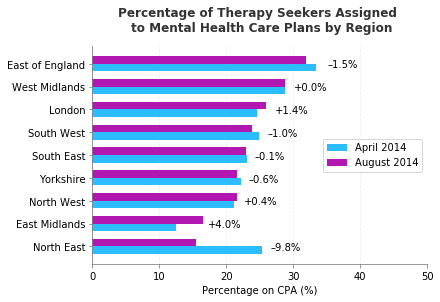

In [149]:
plot_region_pcts(mh_df)

Overall: Not a great deal of change. **Except** if you're from the North East, where care provision dropped from **5 in 20** people receiving treatment to **3 in 20**.